In [1]:
from api_client import AutoJWTClient
from pprint import pprint
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

client = AutoJWTClient(
    base_url="https://osdarken.pythonanywhere.com/api",
    login_url="/auth/token/",
    email="f4rukseker@gmail.com",
    password=""
)

In [2]:

response = client.get('/medication/medication-logs/?date=month&ordering=date')
data = response.json()
pprint(response.json())

[{'date': '2025-06-30',
  'dose_taken': None,
  'dose_time': 27,
  'dose_unit': '',
  'id': 257,
  'medication': 3,
  'medication_name': 'Imuran 50 Mg Film Kapli Tablet',
  'notes': '',
  'taken_status': 'taken',
  'taken_time': None,
  'time': '12:14:29.374945',
  'user': 1},
 {'date': '2025-06-30',
  'dose_taken': None,
  'dose_time': 25,
  'dose_unit': '',
  'id': 256,
  'medication': 1,
  'medication_name': 'Salmiden',
  'notes': '',
  'taken_status': 'taken',
  'taken_time': None,
  'time': '10:07:45.656335',
  'user': 1},
 {'date': '2025-06-29',
  'dose_taken': None,
  'dose_time': 28,
  'dose_unit': '',
  'id': 255,
  'medication': 3,
  'medication_name': 'Imuran 50 Mg Film Kapli Tablet',
  'notes': '',
  'taken_status': 'taken',
  'taken_time': None,
  'time': '23:20:46.547989',
  'user': 1},
 {'date': '2025-06-29',
  'dose_taken': None,
  'dose_time': 26,
  'dose_unit': '',
  'id': 254,
  'medication': 1,
  'medication_name': 'Salmiden',
  'notes': '',
  'taken_status': 'taken

In [3]:
from IPython.display import Markdown, display
from collections import defaultdict
from datetime import datetime

# Grup verisi (örnek veri burada tekrar tanımlı değilse tanımlamalısın)
grouped = defaultdict(list)
for entry in data:
    grouped[entry['date']].append(entry)

def format_time(raw_time):
    if not raw_time:
        return "-"
    try:
        return datetime.strptime(raw_time.split('.')[0], "%H:%M:%S").strftime("%H:%M:%S")
    except:
        return raw_time

# Markdown render
for date in sorted(grouped.keys(), reverse=True):
    md = f"\n### 📅 {date}\n\n"
    md += "| İlaç Adı | Durum | Saat | Doz Saati | Notlar |\n"
    md += "|----------|--------|-----------|-----------|--------|\n"
    for item in grouped[date]:
        name = item['medication_name']
        status = item['taken_status']
        time = format_time(item['time'])
        dose_time = item['dose_time'] if item['dose_time'] is not None else "-"
        notes = item['notes']
        md += f"| {name} | {status} | {time} | {dose_time} | {notes} |\n"
    display(Markdown(md))



### 📅 2025-06-30

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 12:14:29 | 27 |  |
| Salmiden | taken | 10:07:45 | 25 |  |



### 📅 2025-06-29

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 23:20:46 | 28 |  |
| Salmiden | taken | 22:01:22 | 26 |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 10:15:02 | 27 |  |
| Salmiden | taken | 07:04:08 | 25 |  |



### 📅 2025-06-28

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 21:56:36 | 28 |  |
| Salmiden | taken | 20:29:09 | 26 |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 12:59:49 | 27 |  |
| Salmiden | taken | 09:53:11 | 25 |  |
| Esom 40 Mg | taken | 09:38:28 | 18 |  |



### 📅 2025-06-27

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Salmiden | taken | 20:57:46 | 26 |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 10:16:30 | 27 |  |
| Salmiden | taken | 08:10:44 | 25 |  |



### 📅 2025-06-26

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 19:40:15 | 28 |  |
| Salmiden | taken | 18:13:56 | 26 |  |
| Esom 40 Mg | taken | 17:58:41 | 18 |  |
| Salmiden | taken | 05:51:22 | 25 |  |
| Prednol 4 Mg 20 Tb | pass | 05:19:44 | - |  |



### 📅 2025-06-25

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 20:22:05 | - |  |
| Salmiden | taken | 08:20:38 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 08:20:37 | - |  |
| Esom 40 Mg | pass | 08:20:26 | 18 |  |



### 📅 2025-06-23

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 21:12:17 | - |  |
| Prednol 4 Mg 20 Tb | taken | 18:20:59 | - |  |
| Salmiden | taken | 15:51:11 | - |  |
| Esom 40 Mg | taken | 15:51:09 | 18 |  |



### 📅 2025-06-22

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 21:30:30 | - |  |
| Salmiden | taken | 16:19:21 | - |  |
| Esom 40 Mg | taken | 15:19:34 | 18 |  |
| Prednol 4 Mg 20 Tb | taken | 10:19:34 | - |  |
| Salmiden | taken | 08:39:23 | - |  |



### 📅 2025-06-21

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Salmiden | taken | 23:55:15 | - |  |
| Esom 40 Mg | pass | 11:34:31 | 18 |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 11:34:14 | - |  |
| Prednol 4 Mg 20 Tb | taken | 07:37:49 | - |  |
| Salmiden | taken | 04:42:01 | - |  |



### 📅 2025-06-20

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg 20 Tb | taken | 18:33:59 | - |  |
| Salmiden | taken | 15:24:46 | - |  |
| Esom 40 Mg | taken | 07:39:29 | 18 |  |



### 📅 2025-06-19

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 19:21:01 | - |  |
| Salmiden | taken | 17:09:23 | - |  |
| Prednol 4 Mg 20 Tb | taken | 13:24:36 | - |  |
| Salmiden | taken | 12:22:05 | - |  |
| Esom 40 Mg | taken | 12:14:44 | 18 |  |



### 📅 2025-06-18

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 22:19:50 | - |  |
| Salmiden | taken | 21:53:20 | - |  |
| Prednol 4 Mg 20 Tb | taken | 21:53:18 | - |  |
| Salmiden | taken | 12:51:57 | - |  |
| Esom 40 Mg | taken | 12:51:56 | 18 |  |
| Salofalk 60 Gr 7 Lavman | taken | 11:35:42 | 24 |  |



### 📅 2025-06-17

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg 20 Tb | taken | 19:25:56 | - |  |
| Salmiden | taken | 19:25:28 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 13:28:55 | - |  |
| Salmiden | taken | 11:43:50 | - |  |
| Esom 40 Mg | taken | 11:15:56 | 18 |  |



### 📅 2025-06-16

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg | taken | 19:02:33 | - |  |
| Salmiden | taken | 09:48:47 | - |  |



### 📅 2025-06-15

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 19:28:32 | - |  |
| Esom 40 Mg | pass | 11:53:45 | 18 |  |
| Salmiden | taken | 11:53:38 | - |  |



### 📅 2025-06-14

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Esom 40 Mg | pass | 17:19:40 | 18 |  |
| Prednol 4 Mg | taken | 17:19:39 | - |  |
| Salmiden | taken | 17:19:01 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 14:40:21 | - |  |
| Prednol 4 Mg | taken | 12:39:55 | - |  |
| Salmiden | taken | 11:05:42 | - |  |



### 📅 2025-06-13

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg | taken | 18:02:49 | - |  |
| Salmiden | taken | 16:32:44 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 16:28:56 | - |  |
| Prednol 4 Mg | taken | 10:49:51 | - |  |
| Salmiden | taken | 08:25:16 | - |  |
| Esom 40 Mg | taken | 06:34:02 | 18 |  |



### 📅 2025-06-12

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg | taken | 15:23:49 | - |  |
| Salmiden | taken | 15:23:26 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 13:33:46 | - |  |
| Prednol 4 Mg | taken | 07:29:56 | - |  |
| Salmiden | taken | 05:58:54 | - |  |
| Esom 40 Mg | taken | 05:53:31 | 18 |  |



### 📅 2025-06-11

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 4 Mg | taken | 07:44:52 | - |  |
| Salmiden | taken | 05:59:04 | - |  |
| Esom 40 Mg | taken | 05:59:02 | 18 |  |



### 📅 2025-06-10

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Esom 40 Mg | pass | 18:47:46 | 18 |  |
| Prednol 4 Mg | taken | 18:47:44 | - |  |
| Salmiden | taken | 13:56:38 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 12:22:21 | - |  |
| Prednol 4 Mg | taken | 09:45:31 | - |  |
| Salmiden | taken | 06:46:34 | - |  |



### 📅 2025-06-09

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Esom 40 Mg | pass | 16:09:42 | 18 |  |
| Prednol 4 Mg | taken | 16:09:38 | - |  |
| Salmiden | taken | 14:58:53 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 14:57:00 | - |  |
| Prednol 4 Mg | taken | 08:50:49 | - |  |
| Salmiden | taken | 05:03:43 | - |  |



### 📅 2025-06-08

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 15:24:39 | - |  |
| Prednol 4 Mg | taken | 14:03:36 | - |  |
| Salmiden | taken | 12:43:44 | - |  |
| Prednol 4 Mg | taken | 11:50:37 | - |  |
| Salmiden | taken | 07:45:13 | - |  |
| Esom 40 Mg | taken | 06:55:30 | 18 |  |



### 📅 2025-06-07

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 16 Mg 20 Tb | pass | 21:27:03 | - |  |
| Salmiden | taken | 17:18:37 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 17:16:45 | - |  |
| Prednol 16 Mg 20 Tb | taken | 11:34:56 | - |  |
| Salmiden | taken | 11:34:55 | - |  |
| Esom 40 Mg | pass | 11:34:53 | 18 |  |



### 📅 2025-06-06

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Imuran 50 Mg Film Kapli Tablet | taken | 21:30:50 | - |  |
| Salmiden | taken | 14:23:28 | - |  |
| Prednol 16 Mg 20 Tb | taken | 14:23:27 | - |  |
| Prednol 16 Mg 20 Tb | taken | 13:23:25 | - |  |
| Salmiden | taken | 12:34:27 | - |  |
| Prednol 16 Mg 20 Tb | taken | 06:36:52 | - |  |
| Salmiden | taken | 05:20:30 | - |  |
| Esom 40 Mg | taken | 05:20:28 | 18 |  |



### 📅 2025-06-05

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Salmiden | taken | 23:44:26 | - |  |
| Prednol 16 Mg 20 Tb | taken | 14:22:08 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 11:54:37 | - |  |
| Prednol 16 Mg 20 Tb | taken | 07:52:41 | - |  |
| Salmiden | taken | 07:12:28 | - |  |
| Esom 40 Mg | taken | 07:12:27 | 18 |  |



### 📅 2025-06-04

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 16 Mg 20 Tb | taken | 21:50:00 | - |  |
| Salmiden | taken | 20:36:43 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 13:05:51 | - |  |
| Prednol 16 Mg 20 Tb | taken | 13:05:50 | - |  |
| Salmiden | taken | 06:40:02 | - |  |



### 📅 2025-06-03

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 16 Mg 20 Tb | taken | 20:51:06 | - |  |
| Salmiden | taken | 20:05:33 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 19:41:06 | - |  |
| Esom 40 Mg | taken | 11:39:38 | 18 |  |
| Salmiden | taken | 08:12:32 | - |  |
| Prednol 16 Mg 20 Tb | taken | 08:12:31 | - |  |



### 📅 2025-06-02

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Prednol 16 Mg 20 Tb | taken | 19:13:02 | - |  |
| Salmiden | taken | 17:58:54 | - |  |
| Salmiden | taken | 17:52:20 | - |  |
| Prednol 16 Mg 20 Tb | taken | 17:29:40 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 17:29:39 | - |  |
| Salmiden | taken | 07:02:20 | - |  |



### 📅 2025-06-01

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Salmiden | taken | 23:18:01 | - |  |
| Imuran 50 Mg Film Kapli Tablet | taken | 19:06:58 | - |  |
| Esom 40 Mg | pass | 17:42:27 | 18 |  |
| Prednol 16 Mg 20 Tb | taken | 17:42:22 | - |  |
| Salmiden | taken | 16:35:23 | - |  |
| Esom 40 Mg 28 Enterik Kapli Mikropellet Kap | taken | 16:35:21 | - |  |


# PANDAS ILE EXCEL CIKTISI

In [ ]:
!pip install pandas openpyxl

In [4]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment
from openpyxl.utils import get_column_letter

def format_time(raw_time):
    if not raw_time:
        return "-"
    try:
        return datetime.strptime(raw_time.split('.')[0], "%H:%M:%S").strftime("%H:%M:%S")
    except:
        return raw_time

# Gruplama ve excel formatına uygun veri hazırlama
grouped = defaultdict(list)
for item in data:
    grouped[item['date']].append(item)

# Excel yazılacak veri yapısı (tarih başlığı + tablo verisi)
rows = []

for date in sorted(grouped.keys(), reverse=True):
    rows.append({"Tarih": f"📅 {date}", "İlaç Adı": "", "Durum": "", "Doz Saati": ""})
    for item in grouped[date]:
        rows.append({
            "Tarih": "",
            "İlaç Adı": item['medication_name'],
            "Durum": item['taken_status'],
            "Doz Saati": format_time(item['time']) if item['time'] is not None else "-",
        })
    rows.append({"Tarih": "", "İlaç Adı": "", "Durum": "", "Doz Saati": ""})  # boşluk satırı

# DataFrame oluştur
df = pd.DataFrame(rows)

# Excel'e yaz
excel_path = "ilac_takip_gelistirilmis.xlsx"
df.to_excel(excel_path, index=False)

# Genişlik ve stil ayarları
wb = load_workbook(excel_path)
ws = wb.active

# Otomatik sütun genişliği ve ortalama
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter
    for cell in col:
        try:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        except:
            pass
    ws.column_dimensions[column].width = max_length + 4
    for cell in col:
        cell.alignment = Alignment(horizontal='center', vertical='center')
        if isinstance(cell.value, str) and cell.value.startswith("📅"):
            cell.font = Font(bold=True)

# Kaydet
wb.save(excel_path)

excel_path


'ilac_takip_gelistirilmis.xlsx'

---

# Sayaçlar

In [5]:
response = client.get('/counter/all/')
pprint(response.json())

[{'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-26', 'total': 1},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-27', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-27', 'total': 2},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-28', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-28', 'total': 1},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-29', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-29', 'total': 2},
 {'counter_id': 3, 'counter_name': 'Mukus', 'date': '2025-05-30', 'total': 1},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-30', 'total': 3},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-30', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-31', 'total': 2},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-31', 'total': 3},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-06-01', 'total': 3},
 {'

In [9]:
def reFrameData(data: list):
    colorMap: dict = {
        "kan": "red",
        "Mukus": "orange",
        "wc": "cyan"
    }
    for const in data:
        const["color"] = colorMap[const["counter_name"]]
    return data
data = reFrameData(response.json())

In [24]:
data

[{'date': '2025-05-26',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 1,
  'color': 'blue'},
 {'date': '2025-05-27',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'blue'},
 {'date': '2025-05-27',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 2,
  'color': 'pink'},
 {'date': '2025-05-28',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'blue'},
 {'date': '2025-05-28',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 1,
  'color': 'pink'},
 {'date': '2025-05-29',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 2,
  'color': 'pink'},
 {'date': '2025-05-29',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'blue'},
 {'date': '2025-05-30',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'blue'},
 {'date': '2025-05-30',
  'counter_id': 3,
  'counter_name': 'Mukus',
  'total': 1,
  'color': 'orange'},
 {'date': '2025-05-30',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 3,
 

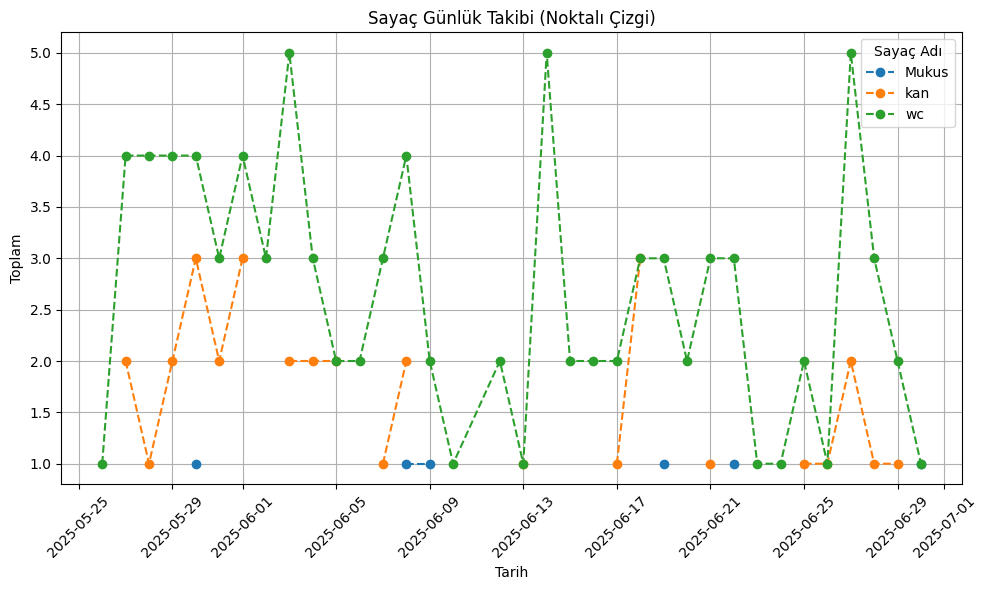

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# API'den gelen veri
data = response.json()

# DataFrame oluştur
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Pivot tablo
pivot_df = df.pivot_table(index='date', columns='counter_name', values='total', aggfunc='sum')

# Grafik çizimi
plt.figure(figsize=(10, 6))
for column in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[column],
        linestyle='--',
        marker='o',
        label=column
    )

plt.title('Sayaç Günlük Takibi (Noktalı Çizgi)')
plt.xlabel('Tarih')
plt.ylabel('Toplam')
plt.grid(True)
plt.legend(title='Sayaç Adı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from IPython.display import HTML

# DataFrame
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Renkleri eşle (her counter_name için 1 renk seçiyoruz)
colors = df.drop_duplicates(subset='counter_name').set_index('counter_name')['color'].to_dict()

# Pivot
pivot_df = df.pivot_table(index='date', columns='counter_name', values='total', aggfunc='sum').fillna(0)
categories = pivot_df.index.strftime('%Y-%m-%d').tolist()

# Series ve renk listesi
series = []
color_list = []

for counter in pivot_df.columns:
    series.append({
        'name': counter,
        'data': pivot_df[counter].tolist()
    })
    color_list.append(colors.get(counter, '#000'))  # varsayılan siyah

# HTML + JS
html = f"""
<div id="chart"></div>
<script src="https://cdn.jsdelivr.net/npm/apexcharts"></script>
<script>
    var options = {{
        chart: {{
            type: 'line',
            height: 400
        }},
        colors: {color_list},
        series: {series},
        xaxis: {{
            categories: {categories}
        }},
        markers: {{
            size: 6
        }},
        stroke: {{
            curve: 'straight'
        }},
        title: {{
            text: 'Sayaç Takibi (Renkli)',
            align: 'left'
        }}
    }};

    var chart = new ApexCharts(document.querySelector("#chart"), options);
    chart.render();
</script>
"""

HTML(html)
